# Data of a complex model with induced magnetization

This notebook generates a toal field anomaly (TFA) and an amplitude of the anomalous magnetic field (AMF) data from a complex model in a regular grid or flightlines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from matplotlib import colors, ticker, cm
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from fatiando.vis import mpl

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

### The model

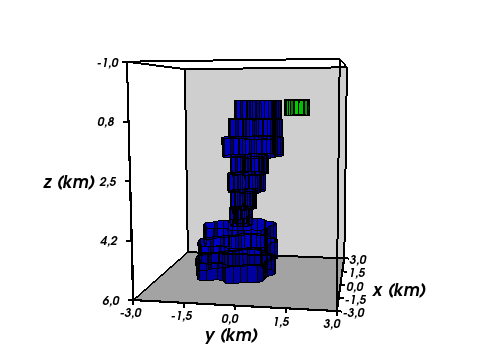

In [3]:
img(filename='data/complex_90_z0130.png')

### Importing model and grid

In [4]:
model_dir = 'data/model_90_z0130.pickle'
#grid_dir = '../grids/flightlines_grid_2100pts_100km2_-150m.pickle'
#grid_dir = '../grids/regular_grid_50x50_100km2_-150m.pickle'

In [5]:
with open(model_dir) as w:
        model = pickle.load(w)

In [6]:
df = pd.read_csv('../diorama/diorama_decimated_tfa.txt', sep=' ', header=0)

In [7]:
grid = dict()

In [8]:
grid['x'] = df['X'].get_values() - np.mean(df['X'].get_values())
grid['y'] = df['Y'].get_values() - np.mean(df['Y'].get_values())
grid['z'] = - df['GPSALT'].get_values() + 430
grid['N'] = df['X'].get_values().size

In [9]:
data = dict()

In [10]:
data['grid'] = [grid['x'], grid['y'],
                            grid['z'], grid['N'],
                            '_real_obs_pts']
mypath = 'data/real_obs_pts'
if not os.path.isdir(mypath):
    os.makedirs(mypath)

### Generating data

In [11]:
# main field
data['main_field'] = [-21.5, -18.7]

# TFA data
data['tfa'] = polyprism.tf(grid['x'], grid['y'], grid['z'], \
                           model['prisms'][:-1], data['main_field'][0], data['main_field'][1]) # predict data
data['inter_data'] = polyprism.tf(grid['x'], grid['y'], grid['z'], \
                          [ model['prisms'][-1]], data['main_field'][0], data['main_field'][1]) # interfering data

amp_noise = 5.
data['tfa_obs'] = data['tfa'] + data['inter_data'] + np.random.normal(loc=0., scale=amp_noise,
                                                                       size=grid['N']) # noise corrupted tfa data

In [12]:
# AMF data
data['bx'] = polyprism.bx(grid['x'], grid['y'], grid['z'], model['prisms'])
data['by'] = polyprism.by(grid['x'], grid['y'], grid['z'], model['prisms'])
data['bz'] = polyprism.bz(grid['x'], grid['y'], grid['z'], model['prisms'])

data['amf'] = np.sqrt(data['bx']**2. + data['by']**2. + data['bz']**2.)

data['amf_obs'] = data['amf'] + np.random.normal(loc=0., scale= amp_noise,
                               size=grid['N']) # noise corrupted amf data

In [13]:
# TFA data - upward continuation
data['z_up'] = -2000.

data['tfa_upward'] = polyprism.tf(grid['x'], grid['y'], np.zeros(grid['x'].size) + data['z_up'], 
                           model['prisms'][:-1], data['main_field'][0], data['main_field'][1]) # predict data

data['tfa_upward_obs'] = data['tfa_upward'] + np.random.normal(loc=0., scale=amp_noise,
                               size=grid['N']) # noise corrupted tfa data

### Data ploting

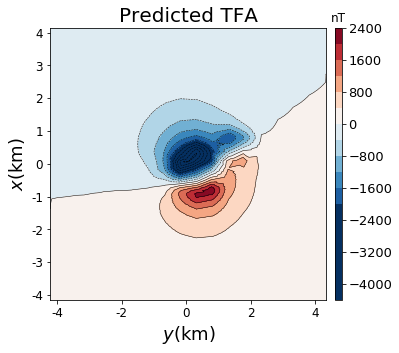

In [14]:
plt.figure(figsize=(6,5))
plt.title('Predicted TFA', fontsize=20)
plt.tricontour(grid['y'], grid['x'], data['tfa']+data['inter_data'], 20, colors='k', linewidths=0.5).ax.tick_params(labelsize=12)
plt.tricontourf(grid['y'], grid['x'], data['tfa']+data['inter_data'], 20, cmap='RdBu_r', vmin=-np.max(data['tfa'])).ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#plt.plot(grid['y'][113:207], grid['x'][113:207], 'ko', markersize=1)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source = mpl.polygon(model['prisms'][-2], '.-k', xy2ne=True)
#source = mpl.polygon(model['prisms'][-1], '.-m', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/pre_tfa.png', dpi=300)
#img(filename=mypath+'/pre_tfa.png')

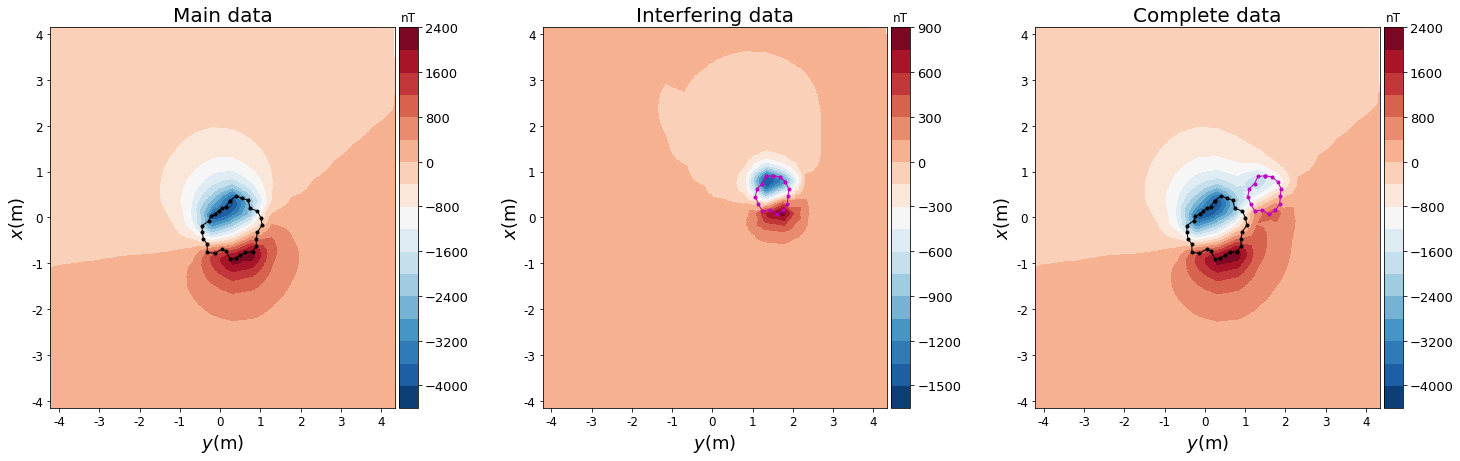

In [15]:
# plot
plt.figure(figsize=(25,7))
plt.subplot(1, 3, 1)
plt.title('Main data', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['tfa'],20, cmap='RdBu_r').ax.tick_params(labelsize=12)
source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
mpl.m2km()

plt.subplot(1, 3, 2)
plt.title('Interfering data', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['inter_data'],20, cmap='RdBu_r').ax.tick_params(labelsize=12)
source = mpl.polygon(model['prisms'][-1], '.-m', xy2ne=True)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
mpl.m2km()

plt.subplot(1, 3, 3)
plt.title('Complete data', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['tfa']+data['inter_data'], 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
source = mpl.polygon(model['prisms'][-1], '.-m', xy2ne=True)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.set_title('nT')
clb.ax.tick_params(labelsize=13)
mpl.m2km()
plt.show()

In [16]:
mask = (grid['y']<-4150.)
grid['y'][mask].size

115

In [17]:
mask = (grid['y']>=-4150.) & (grid['y']<=-3500.)
(grid['x'][113] - grid['x'][0])/grid['y'][mask].size

-79.01519230769303

In [18]:
mask = (grid['y']>=-3500.) & (grid['y']<=-3000.)
(grid['x'][207] - grid['x'][114])/grid['y'][mask].size

73.36189189189122

In [19]:
mask = (grid['y']>=-3000.) & (grid['y']<=-2500.)
(grid['x'][311] - grid['x'][208])/grid['y'][mask].size

-77.6060576923102

In [20]:
mask = (grid['y']>=-2500.) & (grid['y']<=-2000.)
grid['y'][mask].size

115

In [21]:
mask = (grid['y']>=-2000.) & (grid['y']<=-1500.)
grid['y'][mask].size

107

In [22]:
mask = (grid['y']>=-2000.) & (grid['y']<=-1500.)
grid['y'][mask].size

107

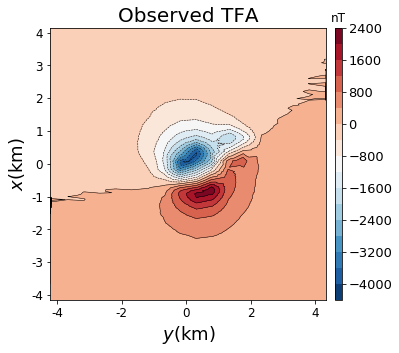

In [23]:
plt.figure(figsize=(6,5))
plt.title('Observed TFA', fontsize=20)
plt.tricontour(grid['y'], grid['x'], data['tfa_obs'], 20, colors='k', linewidths=0.5).ax.tick_params(labelsize=12)
plt.tricontourf(grid['y'], grid['x'], data['tfa_obs'], 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/obs_tfa.png', dpi=300)
#img(filename=mypath+'/obs_tfa.png')

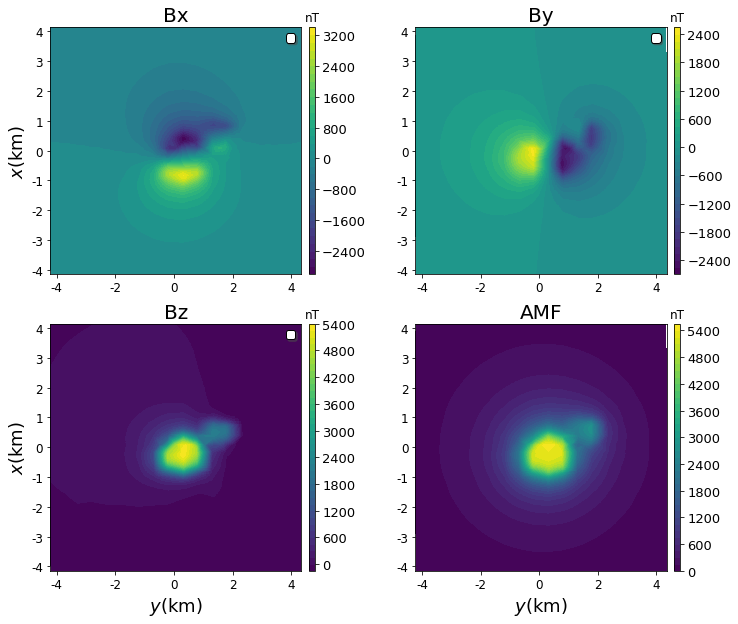

In [24]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.title('Bx', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['bx'], 40, cmap='viridis').ax.tick_params(labelsize=12)
#plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')

plt.subplot(2,2,2)
plt.title('By', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['by'], 40, cmap='viridis').ax.tick_params(labelsize=12)
#plt.xlabel('$y$(km)', fontsize=18)
#plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')

plt.subplot(2,2,3)
plt.title('Bz', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['bz'], 40, cmap='viridis').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')

plt.subplot(2,2,4)
plt.title('AMF', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['amf'], 40, cmap='viridis').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
#plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')

plt.savefig(mypath+'/bcomponents_amf.png', dpi=300)
#img(filename=mypath+'/bcomponents_amf.png')

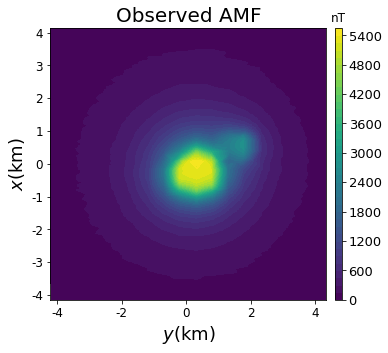

In [25]:
plt.figure(figsize=(6,5))
plt.title('Observed AMF', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['amf_obs'], 40, cmap='viridis').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/obs_amf.png', dpi=300)
#img(filename=mypath+'/obs_amf.png')

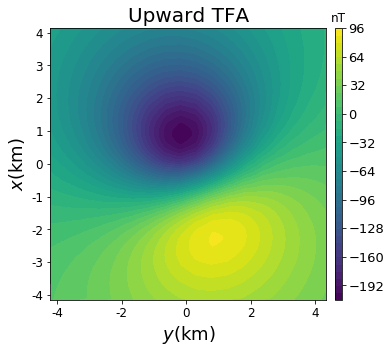

In [26]:
plt.figure(figsize=(6,5))
plt.title('Upward TFA', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['tfa_upward'], 40, cmap='viridis').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/up_pre_tfa.png', dpi=300)
#img(filename=mypath+'/up_pre_tfa.png')

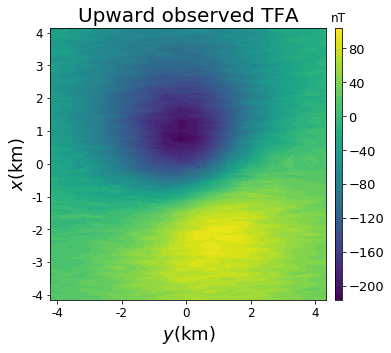

In [27]:
plt.figure(figsize=(6,5))
plt.title('Upward observed TFA', fontsize=20)
plt.tricontourf(grid['y'], grid['x'], data['tfa_upward_obs'], 40, cmap='viridis').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/up_obs_tfa.png', dpi=300)
#img(filename=mypath+'/up_obs_tfa.png')

### Saving in an outer file

In [28]:
file_name = mypath+'/data_90_z0130.pickle'
with open(file_name, 'w') as f:
    pickle.dump(data, f)